In [1]:
import pickle
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import argparse, os
import gpflow
from gpflow import kernels
from likelihoods import *
from data import *
from models import MLSVGP, BASESVGP
from meta_loop import meta_loop
from main import MAIN
from run_main import *
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf

observation_train = pickle.load(open('Inventory_norm_train70.pickle', 'rb'))
observation_test = pickle.load(open('Inventory_norm_test70.pickle', 'rb'))
observation_train = np.log(observation_train)
observation_test = np.log(observation_test)
prices = pickle.load(open('ActualPrices.pickle', 'rb'))
prices_random_train = prices[0 : observation_train.shape[1]].reshape(-1,1)
prices_random_test = prices[observation_train.shape[1]+1 :].reshape(-1,1)
C = np.array(pickle.load(open('LeasedSpace.pickle', 'rb')))
ids_train = np.zeros((observation_train.shape[0], observation_train.shape[1]))
ids_test = np.zeros((observation_test.shape[0], observation_test.shape[1]))


capacity_train = np.zeros((observation_train.shape[0], observation_train.shape[1]))
capacity_test = np.zeros((observation_test.shape[0], observation_test.shape[1]))

actual_price_train = np.zeros((observation_train.shape[0], observation_train.shape[1]))
actual_price_test = np.zeros((observation_test.shape[0], observation_test.shape[1]))

for i in range(observation_train.shape[0]):
    for j in range(observation_train.shape[1]):       
        ids_train[i, j]= i
        capacity_train[i, j] = C[i]
        actual_price_train[i,j] = prices_random_train[j]
        
for i in range(observation_test.shape[0]):
    for j in range(observation_test.shape[1]):       
        ids_test[i, j]= i
        capacity_test[i, j] = C[i]
        actual_price_test[i,j] = prices_random_test[j]
        
prior_observation_train = observation_train[:, :-1].reshape(-1,1)
prior_observation_test = np.concatenate((observation_train[:, -1:], observation_test[:, :-1]), axis =1).reshape(-1,1)


actual_observation_train = observation_train[:, 1:].reshape(-1,1)
actual_observation_test =  observation_test[:, :].reshape(-1,1)

User_capacity_train = capacity_train[:, :-1].reshape(-1,1)
User_capacity_test = np.concatenate((capacity_train[:, -1:], capacity_test[:, :-1]), axis =1).reshape(-1,1)

P_train = actual_price_train[:, 1:].reshape(-1,1)
P_test = actual_price_test[:, :].reshape(-1,1)

actual_ids_train =  ids_train[:, :-1].reshape(-1,1)
actual_ids_test =  ids_test.reshape(-1,1)
print(prior_observation_test.shape, User_capacity_test.shape, P_test.shape , actual_observation_test.shape , actual_ids_test.shape)

dataset_train= np.hstack((prior_observation_train, User_capacity_train, P_train , actual_observation_train , actual_ids_train))

dataset_test= np.hstack((prior_observation_test, User_capacity_test, P_test , actual_observation_test , actual_ids_test))



(48, 1) (48, 1) (48, 1) (48, 1) (48, 1)


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.757114
  Number of iterations: 65
  Number of functions evaluations: 73


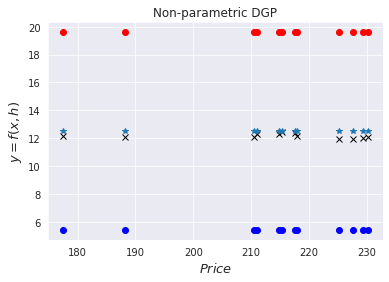

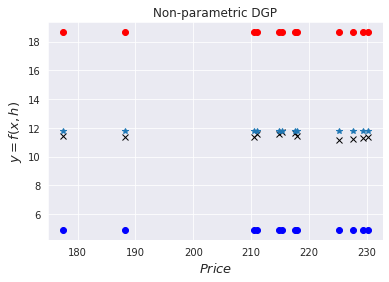

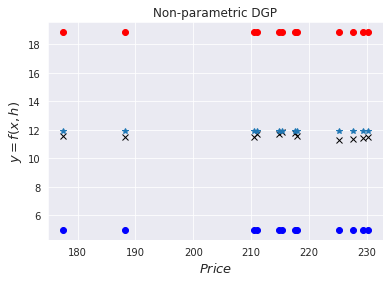

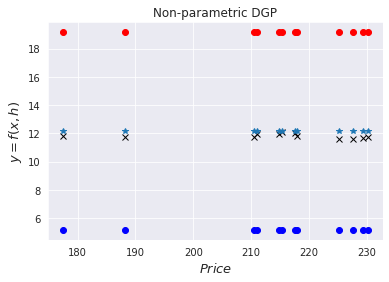

In [2]:
import pickle
num = 10
N = observation_test.shape[0]
M = observation_test.shape[1]
n_Trials = 10000
RMSerror_indGP = [] 
RMSerror = 0
y_pred_GPind = np.zeros((n_Trials, N, M))
experiment_path = "Proportional inventory-experiments-Non_parametric_indGP learning/70/"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
opt_alpha =[]

#for num in range(10,36, 5):
for i in range(N):
    inpt = []
    outpt = []
    for j in range(dataset_train.shape[0]):
        if dataset_train[j, 4] == i:
            inpt.append(dataset_train[j, :3])
            outpt.append(dataset_train[j,3])

    inpt_mu = np.mean(inpt, axis = 0)
    inpt_std = np.std(inpt, axis = 0)
    inpt_mu[1]= capacity_train[i, 0]
    inpt_std[1] = 1
    norm = lambda inp, mu, std: (inp - mu) / std
    inpt_norm = [norm(inp, inpt_mu, inpt_std) for inp in inpt]
    xx_train = np.array(inpt_norm)
    #print(xx_train)


    outpt_mu = np.mean(outpt, axis = 0)
    outpt_std = np.std(outpt, axis = 0)
    outpt_norm = [norm(outp, outpt_mu, outpt_std) for outp in outpt]
    yy_train = np.array(outpt_norm).reshape(-1,1)
    #print(yy_train.shape)
    Z = xx_train[:num, :].copy()
    kernel = gpflow.kernels.RBF(3)
    likelihood = Gaussian()
    m_svgp = gpflow.models.SVGP(xx_train, yy_train, kern=kernel, likelihood=likelihood, Z=Z)

    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m_svgp)
##############################Test

    xx_test= np.zeros((M,3))
    for dim in range(M):
        xx_test[dim,0] = observation_test[i, dim]
        xx_test[dim,1] = capacity_test[i, dim]
        xx_test[dim,2] = actual_price_test[i, dim]

    xx_mu = np.mean(xx_test, axis = 0)
    xx_std = np.std(xx_test, axis = 0)
    xx_mu[1]= capacity_test[i, 0]
    xx_std[1] = 1
    for dim in range(3):
        xx_test[:, dim] = (xx_test[:, dim]- xx_mu[dim])/xx_std[dim]



    mean, var = m_svgp.predict_y(xx_test)
    mean = mean * outpt_std + outpt_mu
    var = var * outpt_std + outpt_mu
    img_path = experiment_path + "/num of inducing points {}/Users/". format(num)
    if not os.path.exists(img_path):
        os.makedirs(img_path)

    img_path = experiment_path + "/num of inducing points {}/Users/". format(num)
    img_path += "/img_user:{}.png".format(i+1)

    plt.figure()
    plt.plot(actual_price_test[0, :], observation_test[i, :].reshape(-1,1), 'kx')    
    plt.plot(actual_price_test[0, :], mean, '*')
    plt.plot(actual_price_test[0, :], mean[:,0] - 2*np.sqrt(var[:,0]), 'bo')
    plt.plot(actual_price_test[0, :], mean[:,0] + 2*np.sqrt(var[:,0]),'ro')
    plt.xlabel('$Price$', fontsize=13)
    plt.ylabel('$y = f(x,h)$', fontsize=13)
    plt.title(('Non-parametric DGP'))
    plt.savefig(img_path)
    obs_test = [x for _,x in sorted(zip(actual_price_test[0,:],observation_test[i,:].reshape(-1)))]
    upp_conf =  [x for _,x in sorted(zip(actual_price_test[0,:], mean[ :] + 2* np.sqrt(var[:])))]
    low_conf =  [x for _,x in sorted(zip(actual_price_test[0,:], mean[ :] - 2* np.sqrt(var[ :])))]
    pred_test =  [x for _,x in sorted(zip(actual_price_test[0,:], mean[ :] ))]
    with open("DGP obs_test user {}.pickle".format(i+1), "wb") as f:
        pickle.dump(obs_test ,f)
    with open("DGP upp_conf user {}.pickle".format(i+1), "wb") as f:
        pickle.dump(upp_conf ,f)
    with open("DGP low_conf user {}.pickle".format(i+1), "wb") as f:
        pickle.dump(low_conf ,f)
    with open("DGP pred_test user {}.pickle".format(i+1), "wb") as f:
        pickle.dump(pred_test ,f)

    for k in range(n_Trials):
        for dim in range(mean.shape[0]):
            y_pred_GPind[k, i, dim] = np.random.normal(mean[dim], np.sqrt(var[dim]), 1)
        RMSerror += sum((observation_test[i, :] - y_pred_GPind[k, i, :])**2)

RMSerror_indGP.append(np.sqrt(RMSerror/ (n_Trials*M*N)))

        ##############
    #Finding the best overbooking level, alpha

#     p = 1
#     c = 1.2
#     T_capacity = 1235000
#     max_prof = 0
#     dscontfac = 0.99
#     Total_cost = 0
#     prof_lst = []
#     for alpha in np.arange(0, 1, 0.01):
#         revenue = (alpha+1) *T_capacity*p
#         for time in range(M):
#             unitcost = 0
#             for itr in range(n_Trials):
#                 sum_inv = 0
#                 for user in range(N):
#                     sum_inv += y_pred_GPind[itr,  user, time]
#                 if (1-alpha)*T_capacity < sum_inv:
#                     unitcost += c*(-(1-alpha)*T_capacity + sum_inv)

#             average_cost= unitcost/n_Trials
#             discounted_cost = (dscontfac**time) * average_cost
#             Total_cost += discounted_cost
#     #         print("discounted_cost", discounted_cost)
#     #     print("Total_cost", Total_cost)
#         profit = revenue - Total_cost
#         prof_lst.append(profit)
#         if profit > max_prof:
#             opt_prof = profit
#             opt_alpha.append(alpha)


# config_path = experiment_path + "/num of inducing points {}/Users/alpha.json".format(num)

# overbooking_value = {}
# overbooking_value['alpha'] = opt_alpha
# with open(config_path, "w") as f:
#     json.dump(overbooking_value, f)   


config_path = experiment_path + "/RMSerror.json"
RMS_indGP = {}
RMS_indGP['RMS'] = RMSerror_indGP
with open(config_path, "w") as f:
    json.dump(RMS_indGP, f)